In [2]:
import numpy as np
from scipy.linalg import lstsq
from scipy.special import hankel1, y0, sph_harm, jv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import ScalarFormatter

In [4]:
# Constants
R = 2.5         # radius of source point sphere
N = 500         # number of source points
M = 500         # number of boundary points
k = 2 * np.pi   # wavenumber

p = np.array([0., 1., 0.])    # polarisation vector
p /= np.linalg.norm(p)        # normalise p
d = np.array([0., 0., -1.],)  # direction unit vector
d /= np.linalg.norm(d)        # normalise d

def E(x):
  """
  E(x) = p e^{ik d \dot x}, d orthogonal to p
    x: array-like, shape (..., 3)
    Returns an array of shape (..., 3)
  """
  return p * np.exp(1j * k * x @ d)[:, None]  # (3,) * (M, 1) -> (M, 3)

def fs(x, y):
  """
  G(x, y) = (I + ∇∇/k²) G₀(x, y), where G₀(r) = e^(ikr)/4πr
    x: boundary point(s), shape (M, 3)
    y: source point(s), shape (N, 3)
    Returns an array of shape (M, N, 3, 3)
  """
  d = x[:, None] - y[None]  # (M, N, 3)
  r = np.linalg.norm(d, axis=2, keepdims=True)  # (M, N, 1)
  kr = k * r
  kr2 = kr ** 2
  fI = (1 + 1j / kr - 1 / kr2) * np.exp(1j * kr) / r  # (M, N, 1, 1)
  fR = (1 + 3j / kr - 3 / kr2) * np.exp(1j * kr) / r  # (M, N, 1, 1)
  I = np.eye(3)[None, None, :, :]  # (1, 1, 3, 3)
  rhat = d / r  # (M, N, 3)
  return (I * fI[..., None] -
         (rhat[..., None] * rhat[..., None, :]) * fR[..., None])  # (M, N, 3, 3)

In [5]:
def sphere(npoints):
  """
  Evenly distribute points on a sphere (Fibonacci lattice)
  https://arxiv.org/pdf/0912.4540.pdf
  """
  golden_ratio = (1 + 5 ** 0.5) / 2
  i = np.arange(0, npoints)
  phi = np.arccos(1 - 2 * i / (npoints - 1))
  theta = 2 * np.pi * i / golden_ratio
  x = np.sin(phi) * np.cos(theta)
  y = np.sin(phi) * np.sin(theta)
  z = np.cos(phi)
  return np.column_stack((x, y, z))  # (npoints, 3)

# Source points
y = R * sphere(N)  # (N, 3)

# Boundary points
x = sphere(M)  # (M, 3)

# Form matrix A
A = fs(x, y)  # (M, N, 3, 3)
A = A.transpose(0, 2, 1, 3)  # (M, 3, N, 3)
A = A.reshape(3 * M, 3 * N)  # (3M, 3N)

# Form vector b
b = E(x)  # (M, 3)
b = b.reshape(3 * M)  # (3M,)

# Solve lstsq for coefficients
alpha, _, _, _ = lstsq(A, b)  # (3N,)

In [6]:
# Create a meshgrid of points on the unit sphere for evaluation
R_sol = 1.0
theta = np.linspace(0, 2 * np.pi, 200)
phi = np.linspace(0, np.pi, 200)
theta, phi = np.meshgrid(theta, phi)
x_plot = R_sol * np.sin(phi) * np.cos(theta)
y_plot = R_sol * np.sin(phi) * np.sin(theta)
z_plot = R_sol * np.cos(phi)
pts = np.stack((x_plot, y_plot, z_plot), axis=-1).reshape(-1, 3)  # (eval_n, 3)

# Compute approximation u^(N)  (eval_n, 3)
u_N = np.sum(fs(pts, y) @ alpha.reshape(N, 3)[..., None], axis=1)[..., 0]

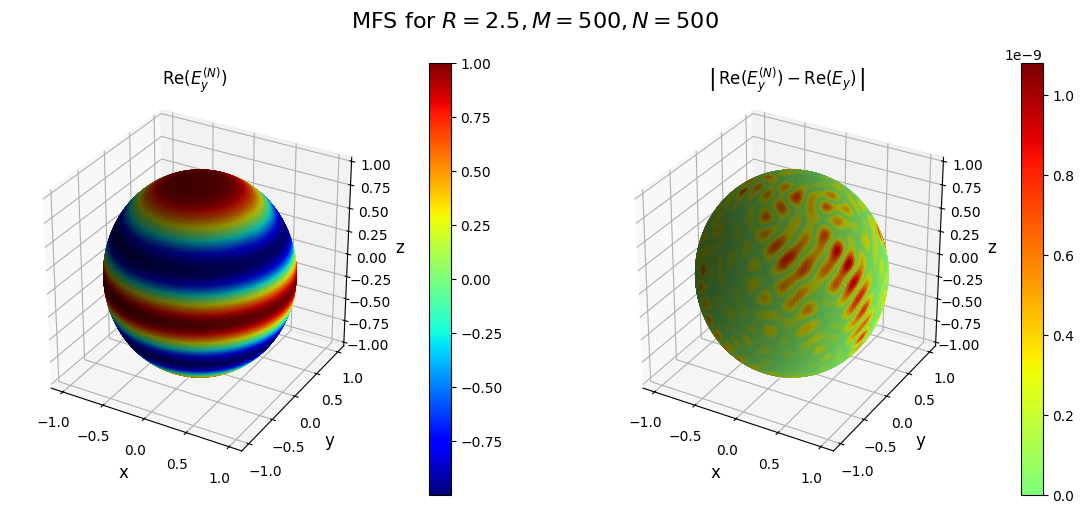

In [7]:
# Compute the real part of the y-component
f = np.real(u_N[:, 1])
f_exact = np.real(E(pts)[:, 1])

# Compute the absolute error.
f_err = np.abs(f - f_exact)

# Reshape the computed field and error to form surfaces
m = int(np.sqrt(pts.shape[0]))
f_surf = f.reshape(m, m)
f_err_surf = f_err.reshape(m, m)

# Normalisation for colorbars
norm_sol = colors.Normalize(vmin=f_surf.min(), vmax=f_surf.max())
norm_err = colors.Normalize(vmin=0, vmax=f_err_surf.max())

# Define upper half of the jet colormap for the error plot
jet_half = colors.LinearSegmentedColormap.from_list(
  'jet_half', plt.cm.jet(np.linspace(0.5, 1, 256))
)

# Prepare subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7),
                               subplot_kw={'projection': '3d'})
fig.suptitle(f"MFS for $R={R}, M={M}, N={N}$", fontsize=16, y=0.88)

# Plot MFS approximation of y-component
surf1 = ax1.plot_surface(
  x_plot, y_plot, z_plot,
  facecolors=plt.cm.jet(norm_sol(f_surf)),
  rstride=1, cstride=1, antialiased=True, alpha=0.8
)
ax1.set_title(r"$\mathrm{Re}(E^{(N)}_y)$")
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_zlabel('z', fontsize=12)
ax1.set_box_aspect([1, 1, 1])
mappable1 = plt.cm.ScalarMappable(norm=norm_sol, cmap=plt.cm.jet)
mappable1.set_array(f_surf)
plt.colorbar(mappable1, aspect=20, ax=ax1, pad=0.1, shrink=0.8)

# Plot the error from the exact solution
surf2 = ax2.plot_surface(
  x_plot, y_plot, z_plot,
  facecolors=jet_half(norm_err(f_err_surf)),
  rstride=1, cstride=1, antialiased=True, alpha=0.8
)
ax2.set_title(r"$\left|\, \mathrm{Re}(E^{(N)}_y)-\mathrm{Re}(E_y)\, \right|$")
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_zlabel('z', fontsize=12)
ax2.set_box_aspect([1, 1, 1])
mappable2 = plt.cm.ScalarMappable(norm=norm_err, cmap=jet_half)
mappable2.set_array(f_err_surf)
plt.colorbar(mappable2, aspect=20, ax=ax2, pad=0.1, shrink=0.8)

plt.show()

<ipython-input-8-1805f934b15e>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.93])


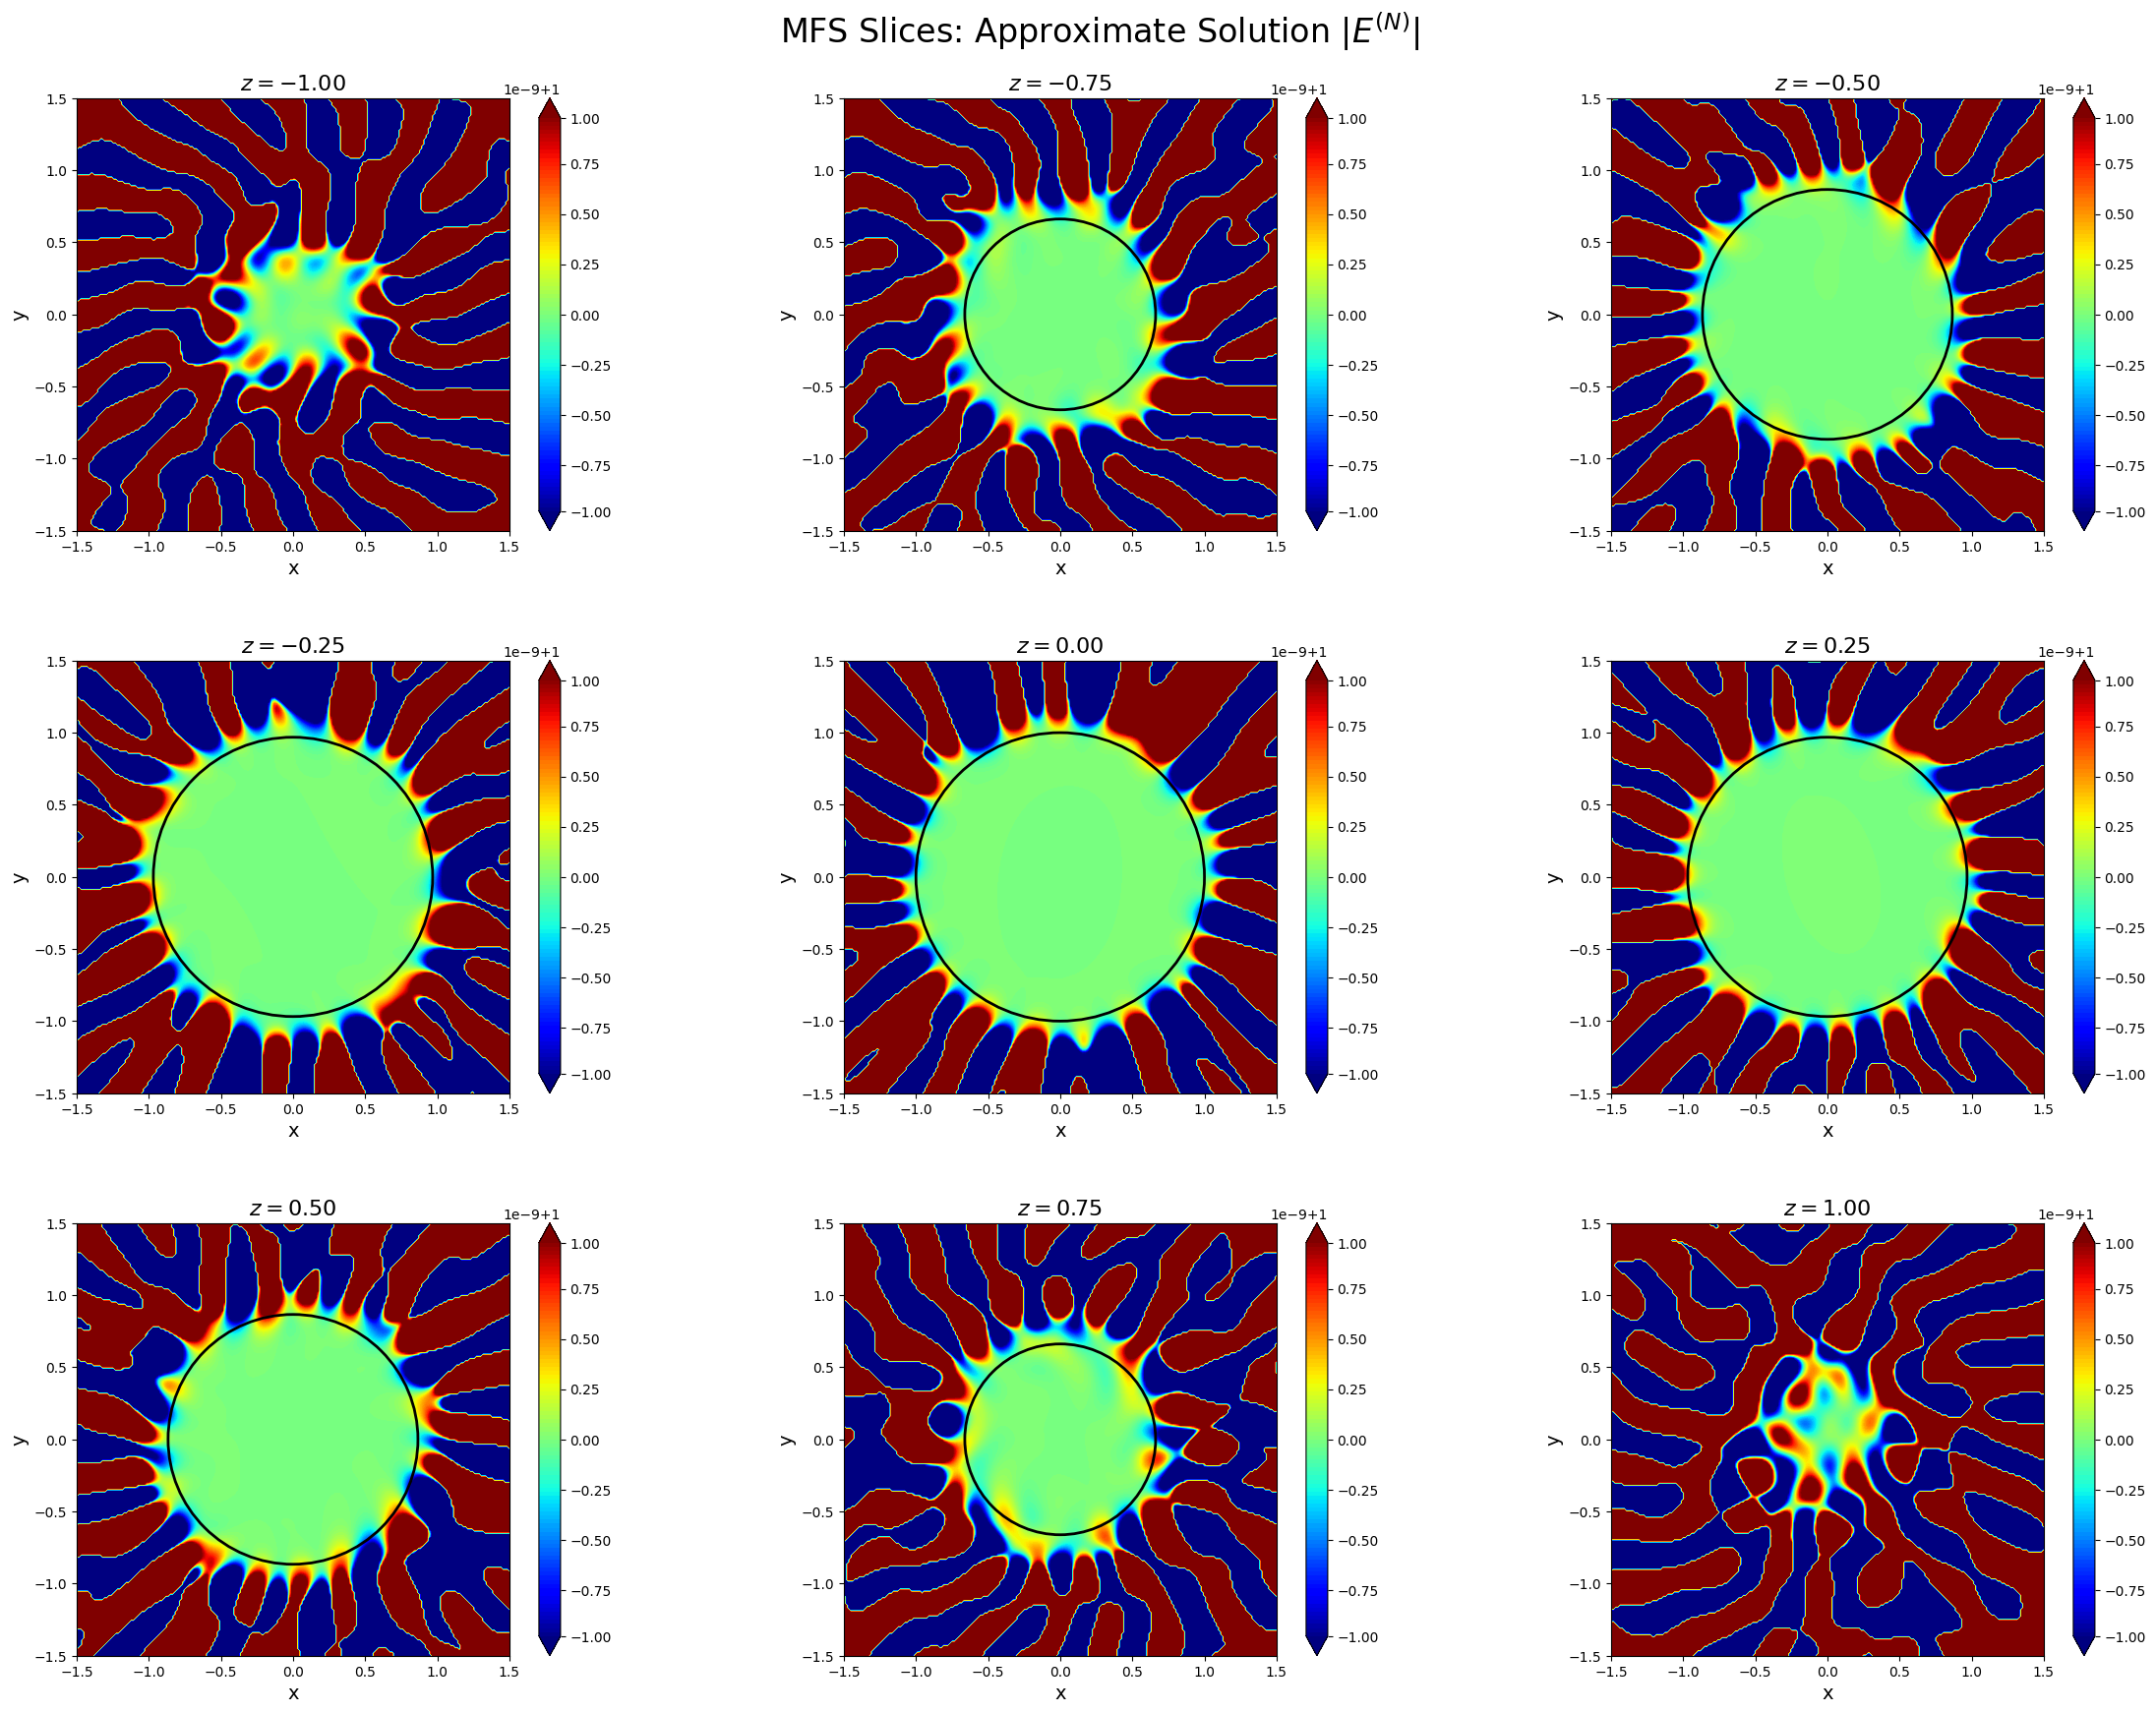

In [8]:
# Contour plot options
opts = {"levels": 100, "cmap": "jet", "extend": "both"}

# Define the z–slice locations
z_slices = np.linspace(-1, 1, 9)

# Set up a testing grid in the x–y plane
n_grid, x_min, x_max = 200, -1.5, 1.5
grid = np.linspace(x_min, x_max, n_grid)
X, Y = np.meshgrid(grid, grid)

# Choose a common normalisation for all contour plots
vmin, vmax = -1e-9, 1e-9
global_norm = TwoSlopeNorm(vmin=1 + vmin, vcenter=1, vmax=1 + vmax)

# Reshape alpha for evaluation
alpha_v = alpha.reshape(-1, 3)

# Prepare the figure and grid layout
fig = plt.figure(figsize=(24, 18))
outer_gs = GridSpec(3, 3, left=0.05, right=0.95, top=0.93, bottom=0.05,
                    wspace=0.3, hspace=0.3)

for i, z in enumerate(z_slices):
  ax = fig.add_subplot(outer_gs[i])

  # Build and flatten the evaluation points for the current z–slice
  pts = np.dstack((X, Y, np.full(X.shape, z))).reshape(-1, 3)

  # Evaluate the approximate solution at these points
  u_approx = np.sum(fs(pts, y) @ alpha_v[..., None], axis=1)[..., 0]

  # Reshape and clip the magnitude of the computed solution
  sol_clipped = np.clip(np.linalg.norm(u_approx, axis=1).reshape(X.shape),
                        1 + vmin, 1 + vmax)

  # Create the contour plot using the shared normalisation
  cs = ax.contourf(X, Y, sol_clipped, norm=global_norm, **opts)

  # Add an outline circle
  ax.add_patch(plt.Circle((0, 0), np.sqrt(max(0, 1 - z**2)),
                            color='black', fill=False, lw=2, zorder=10))

  # Set axis properties and labels
  ax.set_aspect('equal', 'box')
  ax.set_xlabel("x", fontsize=14)
  ax.set_ylabel("y", fontsize=14, labelpad=4)
  ax.set_title(f"$z={z:.2f}$", fontsize=16)

  # Add an individual colorbar for this subplot
  ticks = np.linspace(1 + vmin, 1 + vmax, 9)
  plt.colorbar(cs, ax=ax, pad=0.05, ticks=ticks)

plt.suptitle("MFS Slices: Approximate Solution $|E^{(N)}|$",
             fontsize=24, y=0.98)
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.93])
plt.show()

N = 100
N = 200
N = 300
N = 400
N = 500
N = 600
N = 700
N = 800
N = 900
N = 1000
N = 1100
N = 1200
N = 1300
N = 1400
N = 1500


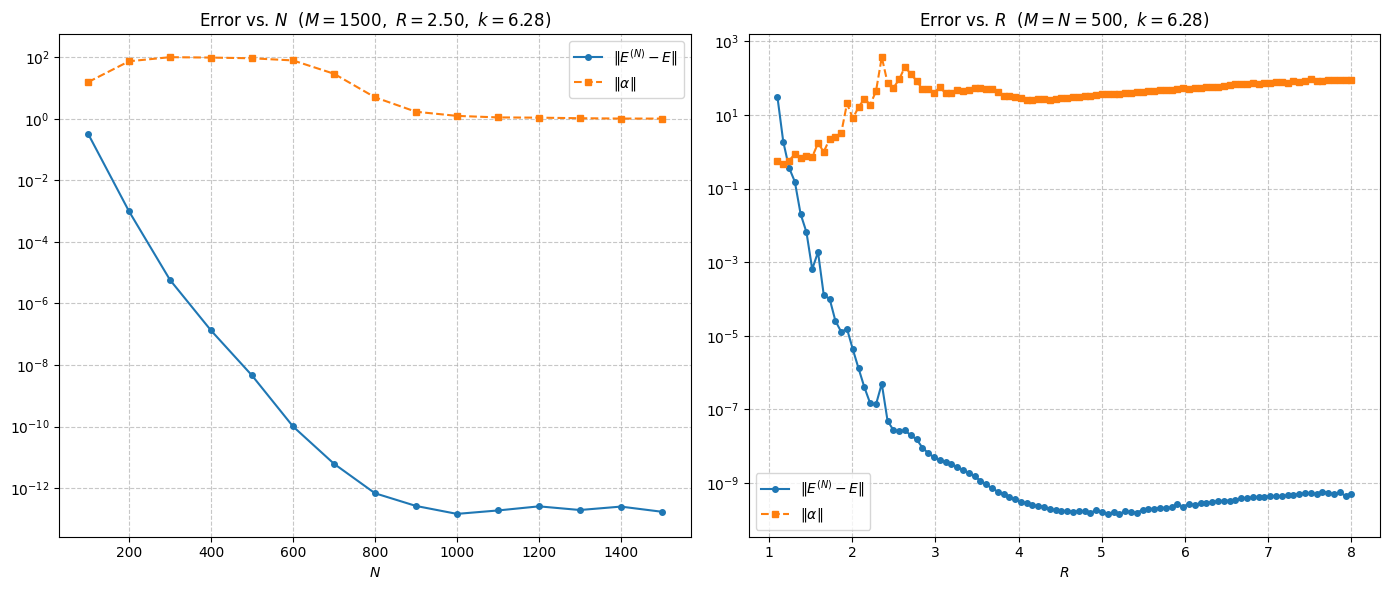

In [9]:
# Create evaluation grid
n_eval_theta = 50
n_eval_phi = 50
theta = np.linspace(0, 2 * np.pi, n_eval_theta)
phi = np.linspace(0, np.pi, n_eval_phi)
Theta, Phi = np.meshgrid(theta, phi)
pts_eval = np.stack((np.sin(Phi) * np.cos(Theta),
                   np.sin(Phi) * np.sin(Theta),
                   np.cos(Phi)), axis=-1).reshape(-1, 3)

def mfs(M, N, R):
  """
  Computes the L2 error of the real parts on the evaluation grid and
  the norm of the source strengths alpha, given:
    M           : number of boundary points
    N           : number of source points
    R           : sphere scaling factor for the source points
    source_func : source point generating function
  """
  # Boundary and source points
  x = sphere(M)
  y = sphere(N) * R

  # Assemble MFS matrix
  A = fs(x, y)  # (N, M, 3, 3)
  A = A.transpose(0, 2, 1, 3).reshape(3 * M, 3 * N)

  # Assemble the right-hand side
  b = E(x).reshape(3 * M)

  # Solve for alpha
  alpha, _, _, _ = lstsq(A, b)

  # Evaluate the MFS approximation on pts_eval
  fs_eval = fs(pts_eval, y)  # shape: (n_eval, M, 3, 3)
  alpha_v = alpha.reshape(N, 3)  # shape: (M,3)
  u_approx = np.sum(fs_eval @ alpha_v[..., None], axis=1)[..., 0]

  # Compute the exact solution
  u_exact = E(pts_eval)

  # Compute the error and alpha norms
  error = u_approx - u_exact
  err_norm = np.linalg.norm(error)
  alpha_norm = np.linalg.norm(alpha)

  return err_norm, alpha_norm

# Variation with respect to N for fixed R
R_fixed = 2.5
M_fixed = 1500
N_vals = np.arange(100, M_fixed + 1, 100)
err_N, alpha_N = [], []
for N in N_vals:
  print("N =", N)
  err, a_norm = mfs(M_fixed, N, R_fixed)
  err_N.append(err)
  alpha_N.append(a_norm)

# Variation with respect to R (with M = N fixed)
M_fixed2 = 500
R_vals = np.linspace(1.1, 8, 100)
err_R = []
alpha_R = []
for R_val in R_vals:
  err, a_norm = mfs(M_fixed2, M_fixed2, R_val)
  err_R.append(err)
  alpha_R.append(a_norm)

# Prepare subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot: Error and alpha-norm vs. N for fixed R
ax1.semilogy(N_vals, err_N, 'o-', markersize=4, label=r'$\|E^{(N)}-E\|$')
ax1.semilogy(N_vals, alpha_N, 's--', markersize=4, label=r'$\|\alpha\|$')
ax1.set_xlabel(r'$N$')
ax1.set_title(r'Error vs. $N$  ($M=%d,\ R=%.2f,\ k=%.2f$)'
               % (M_fixed, R_fixed, k))
ax1.legend()
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

# Plot: Error and alpha-norm vs. R for fixed M = N
ax2.semilogy(R_vals, err_R, 'o-', markersize=4, label=r'$\|E^{(N)}-E\|$')
ax2.semilogy(R_vals, alpha_R, 's--', markersize=4, label=r'$\|\alpha\|$')
ax2.set_xlabel(r'$R$')
ax2.set_title(r'Error vs. $R$  ($M=N=%d,\ k=%.2f$)' % (M_fixed2, k))
ax2.legend()
ax2.grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()